In [15]:
import sys

import matplotlib.pyplot as plt
from ase.io import read

import numpy as np
sys.path.insert(0, "../LML_retrain/")
from LML_retrain import LMLPotential 

import os

from ase.io import read

from ase.calculators.lammpslib import LAMMPSlib
from ase.constraints import FixAtoms

def make_ML_calc(potentails_folder="../potentials",
                 pot_name="W_milady"):

    pot_files = [f"{pot_name}.snapcoeff", f"{pot_name}.snapparam"]
    pot_paths = [os.path.join(potentails_folder, pot_file) for pot_file in pot_files]
    pot_path = " ".join(pot_paths)

    ML_calc = LAMMPSlib(lmpcmds=["pair_style snap",
                                 "pair_coeff * * %s W" % pot_path],
                        atom_types={'W': 1}, keep_alive=True)
    return ML_calc

def add_fix_atoms_to_image(image):

    if "fix_mask" in image.arrays:

        if len(image.constraints) == 0:

            # print("Adding fixed atoms constraint")

            fix_mask = image.get_array("fix_mask")
            fix_atoms = FixAtoms(mask=fix_mask)
            image.set_constraint(fix_atoms)

        # else:
            # print("Constraints list is not zero")
    else:
        raise RuntimeError("No fixmask array to add fixed atoms")

    return None


In [46]:
def plot_ML_vs_target_forces(QMML_images, retrained_lml,
                             retrained_LML_label="", plot_force_error=0.01, ax=None):
    
    if len(retrained_LML_label):
        retrained_LML_label = retrained_LML_label + " "

    original_lml = make_ML_calc(pot_name="milady_lml", potentails_folder="../potentials/")
    

    for image in QMML_images:
        add_fix_atoms_to_image(image)

    target_forces = []
    lml_forces = []
    retrained_lml_forces = []

    
    for image in QMML_images:
        QM_mask = image.get_array("region") == "QM"
        target_forces.append(image.get_forces()[QM_mask])
        
        lml_image = image.copy()
        lml_image.calc = original_lml
        lml_forces.append(lml_image.get_forces()[QM_mask])

        retrained_lml_image = image.copy()
        retrained_lml_image.calc = retrained_lml
        retrained_lml_forces.append(retrained_lml_image.get_forces()[QM_mask])

    target_forces = np.concatenate(target_forces)
    lml_forces = np.concatenate(lml_forces)
    retrained_lml_forces = np.concatenate(retrained_lml_forces)
    
    if ax is None:
        fig, ax = plt.subplots()
    
    lml_rms = (lml_forces - target_forces).std() 
    ax.scatter(target_forces.flatten(), lml_forces.flatten(), 
               label=f"Original LML RMSE = {lml_rms:2.2g} eV/A")
    
    retrained_lml_rms = (retrained_lml_forces - target_forces).std() 
    ax.scatter(target_forces.flatten(), retrained_lml_forces.flatten(),
                label=f"{retrained_LML_label}Retrained LML RMSE = {retrained_lml_rms:2.2g} eV/A")

    error_points = np.linspace(target_forces.flatten().min(),
                               target_forces.flatten().max(), 11)

    ax.plot(error_points, error_points, linestyle="dashed", c="grey")

    ax.set_xlabel(r"QM Forces (eV/$\rm\AA$)")
    ax.set_ylabel(r"ML Forces (eV/$\rm\AA$)")
    
    ax.legend(loc="upper left")
    ymin, ymax = ax.get_ylim()
    ax.set_ylim((ymin, 1.4 * ymax))
    
    original_lml.lmp.close()

In [3]:
QMML_screw_images = read("../data_files/QMML_glide_images/screw_vasp_LML_6_12_004.xyz", index=":")
screw_retrained_lml = make_ML_calc(pot_name="qSNAPScrewBulkMDVacNEB_Lam0_500_LamS_1", potentails_folder="../potentials/Lam0_500_LamS_1/")

QMML_junction110_images = read("../data_files/QMML_glide_images/edge100110_vasp_LML_6_10_007.xyz", index=":")
junction110_retrained_lml = make_ML_calc(pot_name="qSNAPJunction110BulkMDVacNEB_Lam0_500_LamS_1", potentails_folder="../potentials/Lam0_500_LamS_1/")

QMML_junction100_images = read("../data_files/QMML_glide_images/edge100_vasp_LML_6_10_019.xyz", index=":")
junction100_retrained_lml = make_ML_calc(pot_name="qSNAPJunction100BulkMDVacNEB_Lam0_500_LamS_1", potentails_folder="../potentials/Lam0_500_LamS_1/")

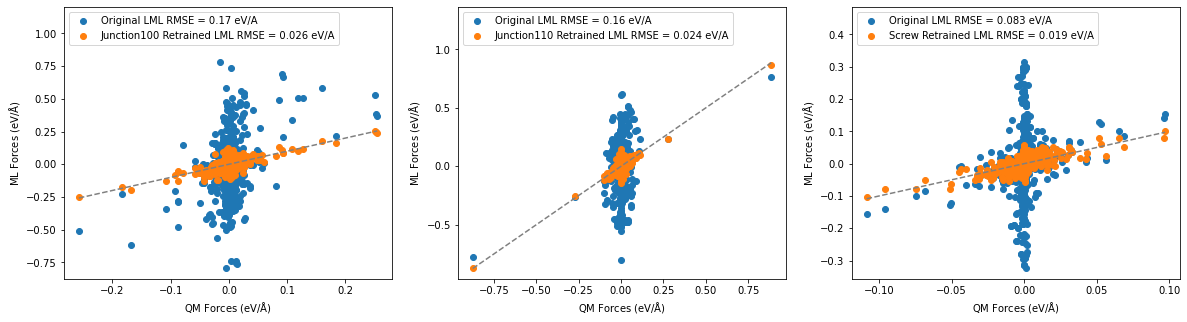

In [4]:
fig, axes = plt.subplots(figsize=(20, 5), ncols=3)

plot_ML_vs_target_forces(QMML_images=QMML_junction100_images,
                        retrained_lml=junction100_retrained_lml, retrained_LML_label="Junction100", ax=axes[0])
plot_ML_vs_target_forces(QMML_images=QMML_junction110_images,
                        retrained_lml=junction110_retrained_lml, retrained_LML_label="Junction110", ax=axes[1])
plot_ML_vs_target_forces(QMML_images=QMML_screw_images,
                        retrained_lml=screw_retrained_lml, retrained_LML_label="Screw", ax=axes[2])

In [17]:
train_configs = read("../data_files/bulk_MD_train.xyz", index=":")
test_config = read("../data_files/bulk_MD_test.xyz")
eos_configs = read("../data_files/eos_configurations.xyz", index=":")

In [18]:
def plot_pot_summary(QMML_images, pot_name, axes, as_label="test", ah_label="test"):
    
    LML_pot = LMLPotential("../potentials/milady_lml")

    LML_pot.new_theta =  np.loadtxt(f"../potentials/Lam0_500_LamS_1/{pot_name}.snapcoeff", skiprows=6)

    retrained_lml = make_ML_calc(pot_name=pot_name, potentails_folder="../potentials/Lam0_500_LamS_1/")
    plot_ML_vs_target_forces(QMML_images=QMML_images,
                            retrained_lml=retrained_lml, retrained_LML_label="", ax=axes[0])
    LML_pot.plot_MD_test_train_atoms(test_config, train_configs, ax=axes[1], title="Bulk MD forces")
    LML_pot.plot_eos_data(eos_configs, ax=axes[2])
    LML_pot.plot_w_coefs(ax=axes[3])

In [19]:
def make_figure(dislocation="Screw"):
    fig, big_axes = plt.subplots(figsize=(19, 12) , nrows=3, ncols=1, sharey=True) 

    for row, big_ax in enumerate(big_axes, start=1):
        big_ax.set_axis_off()
        # removes the white frame
        big_ax._frameon = False
    
    def make_title(as_label, ah_label):
        return f"LML retrained on {dislocation} glide with " + r"${\bf A}_{\rm S}$: " + as_label + r"; ${\bf A}_{\rm H}:$ " + ah_label
    
    for ax, title in zip(big_axes, [make_title("Bulk MD", "EOS"),
                                    make_title("Vacancy MD", "EOS"),
                                    make_title("Bulk MD", "EOS + Vacancy migration NEB")]):
        ax.set_title(title, fontsize=14, pad=15)


    for i in range(0, 3):
        row = []
        for k in range(1, 5):
            ax = fig.add_subplot(3, 4, k + 4 * i)

    return fig

In [10]:
import matplotlib as mpl

Train RMSE = 0.0078 eV/A
Test RMSE = 0.0097 eV/A
Train RMSE = 0.025 eV/A
Test RMSE = 0.0093 eV/A
Train RMSE = 0.0079 eV/A
Test RMSE = 0.0098 eV/A


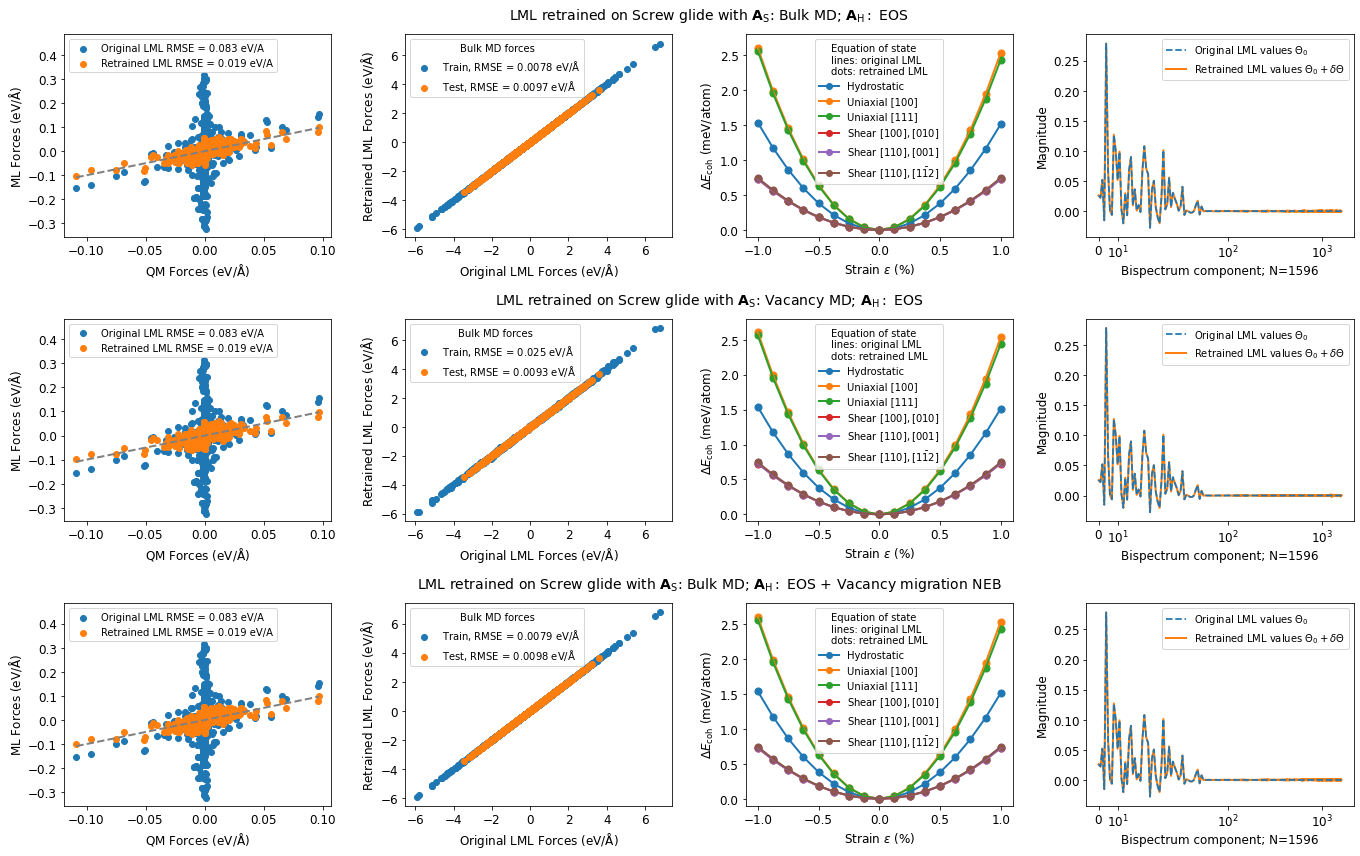

In [23]:
with mpl.rc_context({'lines.linewidth': 2, 
                     "font.size": 10, "legend.fontsize": 10, "legend.title_fontsize" : 10,
                     "xtick.labelsize": 12,
                     "ytick.labelsize": 12,
                     "axes.labelsize": 12}):
    fig =  make_figure(dislocation="Screw")
    axes = fig.get_axes()

    QMML_screw_images = read("../data_files/QMML_glide_images/screw_vasp_LML_6_12_004.xyz", index=":")

    pot_name = "qSNAPScrewBulkMD_Lam0_500_LamS_1"
    plot_pot_summary(QMML_screw_images, pot_name, axes[3:7], as_label="Bulk MD", ah_label="EOS")

    pot_name = "qSNAPScrewVacMD_Lam0_500_LamS_1"
    plot_pot_summary(QMML_screw_images, pot_name, axes[7:11], as_label="Vacancy MD", ah_label="EOS")

    pot_name = "qSNAPScrewBulkMDVacNEB_Lam0_500_LamS_1"
    plot_pot_summary(QMML_screw_images, pot_name, axes[11:15], as_label="Bulk MD", ah_label="EOS + Vacancy migration NEB")

    fig.tight_layout()

In [24]:
fig.savefig("SM_screw_retraining.pdf")

Train RMSE = 0.01 eV/A
Test RMSE = 0.012 eV/A
Train RMSE = 0.028 eV/A
Test RMSE = 0.013 eV/A
Train RMSE = 0.01 eV/A
Test RMSE = 0.012 eV/A


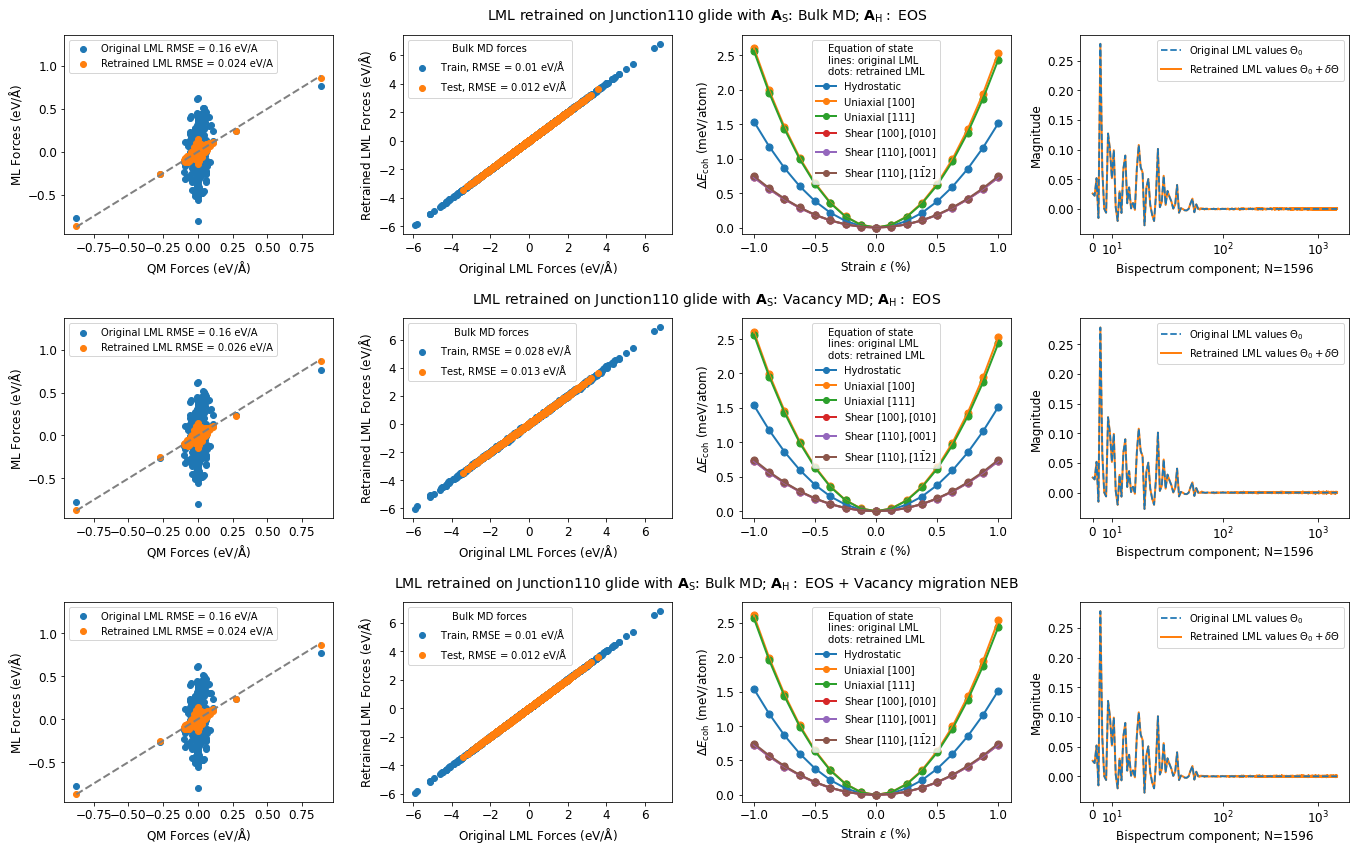

In [25]:
with mpl.rc_context({'lines.linewidth': 2, 
                     "font.size": 12, "legend.fontsize": 10, "legend.title_fontsize" : 10,
                     "xtick.labelsize": 12,
                     "ytick.labelsize": 12,
                     "axes.labelsize": 12}):
    fig =  make_figure(dislocation="Junction110")
    axes = fig.get_axes()
    QMML_junction110_images = read("../data_files/QMML_glide_images/edge100110_vasp_LML_6_10_007.xyz", index=":")

    pot_name = "qSNAPJunction110BulkMD_Lam0_500_LamS_1"
    plot_pot_summary(QMML_junction110_images, pot_name, axes[3:7], as_label="Bulk MD", ah_label="EOS")

    pot_name = "qSNAPJunction110VacMD_Lam0_500_LamS_1"
    plot_pot_summary(QMML_junction110_images, pot_name, axes[7:11], as_label="Vacancy MD", ah_label="EOS")

    pot_name = "qSNAPJunction110BulkMDVacNEB_Lam0_500_LamS_1"
    plot_pot_summary(QMML_junction110_images, pot_name, axes[11:15], as_label="Bulk MD", ah_label="EOS + Vacancy migration NEB")

    fig.tight_layout()

In [26]:
fig.savefig("SM_junction110_retraining.pdf")

Train RMSE = 0.012 eV/A
Test RMSE = 0.014 eV/A
Train RMSE = 0.035 eV/A
Test RMSE = 0.013 eV/A
Train RMSE = 0.012 eV/A
Test RMSE = 0.014 eV/A


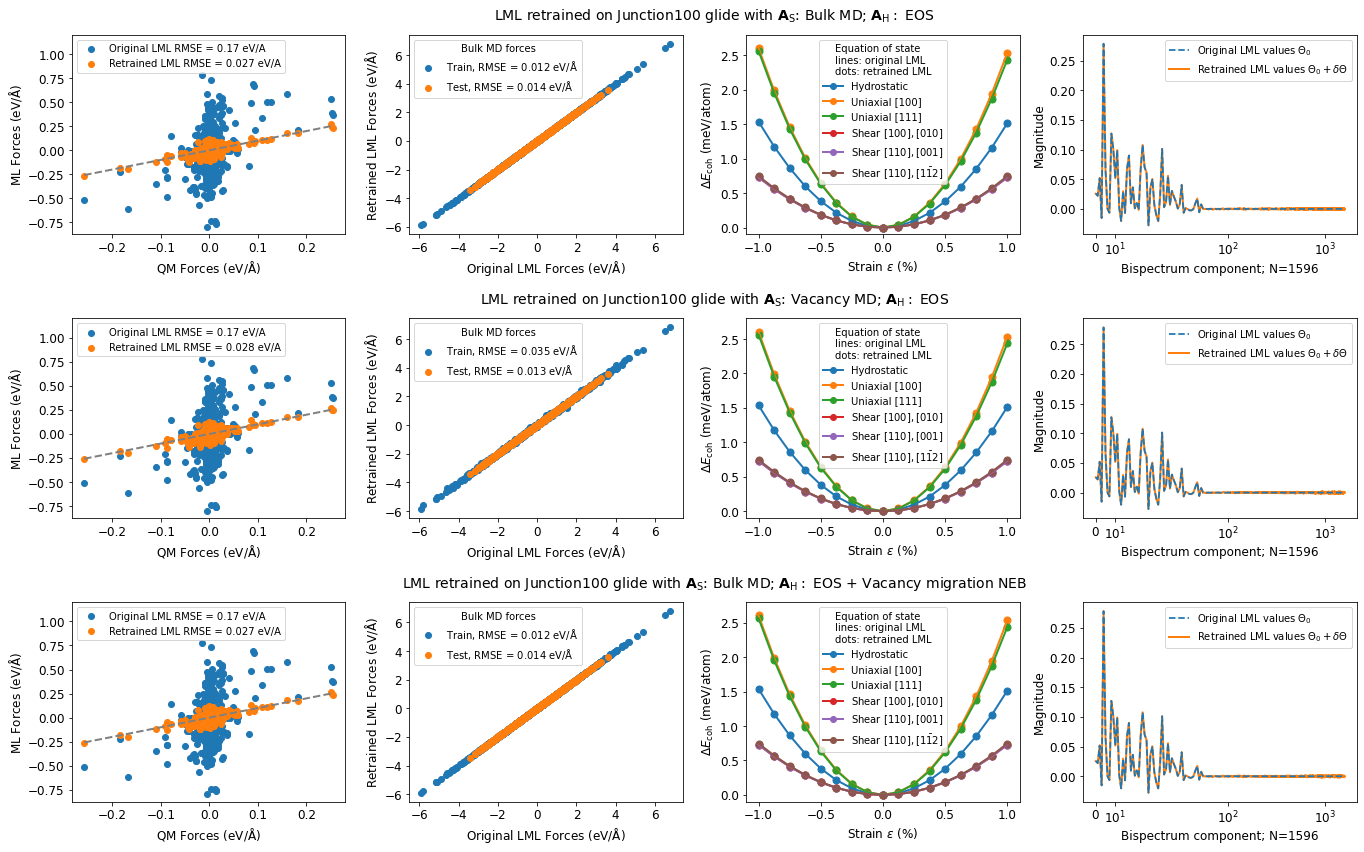

In [27]:
with mpl.rc_context({'lines.linewidth': 2, 
                     "font.size": 12, "legend.fontsize": 10, "legend.title_fontsize" : 10,
                     "xtick.labelsize": 12,
                     "ytick.labelsize": 12,
                     "axes.labelsize": 12}):
    fig =  make_figure(dislocation="Junction100")
    axes = fig.get_axes()
    QMML_junction100_images = read("../data_files/QMML_glide_images/edge100_vasp_LML_6_10_019.xyz", index=":")

    pot_name = "qSNAPJunction100BulkMD_Lam0_500_LamS_1"
    plot_pot_summary(QMML_junction100_images, pot_name, axes[3:7], as_label="Bulk MD", ah_label="EOS")

    pot_name = "qSNAPJunction100VacMD_Lam0_500_LamS_1"
    plot_pot_summary(QMML_junction100_images, pot_name, axes[7:11], as_label="Vacancy MD", ah_label="EOS")

    pot_name = "qSNAPJunction100BulkMDVacNEB_Lam0_500_LamS_1"
    plot_pot_summary(QMML_junction100_images, pot_name, axes[11:15], as_label="Bulk MD", ah_label="EOS + Vacancy migration NEB")

    fig.tight_layout()

In [28]:
fig.savefig("SM_junction100_retraining.pdf")

In [43]:
from ase.calculators.singlepoint import SinglePointCalculator

junction_vac_ini = read("../data_files/relaxed_vac_at_junction110_ini.xyz")
junction_vac_fin1 = read("../data_files/relaxed_vac_at_junction110_fin1.xyz")
junction_vac_fin2 = read("../data_files/relaxed_vac_at_junction110_fin2.xyz")

LML_pot = LMLPotential("../potentials/milady_lml")

junction_vac_images = []
for image in [junction_vac_ini, junction_vac_fin1, junction_vac_fin2]:
    region = image.get_array("region")
    QM_mask = region == "QM"
    qm_positions = image.positions[QM_mask]
    positions = image.positions
    qm_plus_10_a_mask = [all(row) for row in np.logical_and(positions > qm_positions.min(axis=0) - 10, positions < qm_positions.max(axis=0) + 10)]
    
    screened_forces = image.get_forces()[qm_plus_10_a_mask]
    screened_image = image.copy()[qm_plus_10_a_mask]
    screened_image.calc = SinglePointCalculator(screened_image,
                                                forces=screened_forces)
    
    junction_vac_images.append(screened_image)


In [48]:
QMML_junction110_images = read("../data_files/QMML_glide_images/edge100110_vasp_LML_6_10_007.xyz", index=":")

Train RMSE = 0.013 eV/A
Test RMSE = 0.015 eV/A


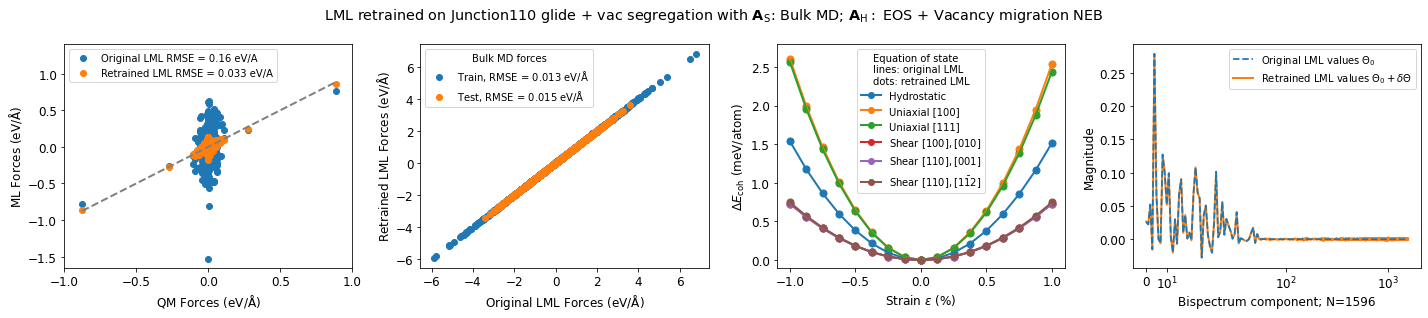

In [58]:
with mpl.rc_context({'lines.linewidth': 2, 
                     "font.size": 12, "legend.fontsize": 10, "legend.title_fontsize": 10,
                     "xtick.labelsize": 12,
                     "ytick.labelsize": 12,
                     "axes.labelsize": 12}):
    fig, axes = plt.subplots(figsize=(20, 4.5) , ncols=4) 

    fig.suptitle(f"LML retrained on Junction110 glide + vac segregation with " +
                 r"${\bf A}_{\rm S}$: " + "Bulk MD" + r"; ${\bf A}_{\rm H}:$ " + "EOS + Vacancy migration NEB")

    pot_name = "qSNAPJunction110BulkMDVacNEBSegregation_Lam0_500_LamS_1"
    plot_pot_summary(QMML_junction110_images + junction_vac_images, pot_name, axes, as_label="Bulk MD", ah_label="EOS + Vacancy migration NEB")
    axes[0].set_xlim((-1.0, 1.0))
    axes[0].set_xticks((-1.0, -0.5, 0.0, 0.5, 1.0))
    fig.tight_layout()

In [59]:
fig.savefig("SM_segregation_retraining.pdf")